# Laugh test 1: Storage and transmission in soils
This notebook plots SUMMA simulations for the test case defined in Celia et al. (1990). 

## Expectations
The simulations should reproduce Figure 6 in Celia et al. (1990):

![Figure 6a in Celia et al. (1990)](https://raw.githubusercontent.com/CH-Earth/laughTests/master/lt1_celia1990/img/celia1990_fig6.png?token=ABZLT4QHL6TTO53YA2V4CP27DMWDU)

## Meta data

| Data  | Value  |
|:---|:---|
| Model name| Structure for Unifying Multiple Modelling Alternatives (SUMMA) |
| Model version  | See attributes in output .nc file |
| Model reference | Clark et al. (2015a,b) |
| Model runs by | R. Zolfaghari |
| Notebook code by | W. Knoben, A. Bennett |
    
## Reference(s)
Celia, M. A., E. T. Bouloutas, and R. L. Zarba (1990), A general mass conservative numerical solution for the unsaturated flow equation, Water Resour. Res., 26(7), 1483–1496, doi:10.1029/WR026i007p01483

Clark, M. P., Nijssen, B., Lundquist, J. D., Kavetski, D., Rupp, D. E., Woods, R. A., … Rasmussen, R. M. (2015a). A unified approach for process-based hydrologic modeling: 1. Modeling concept. Water Resources Research, 51(4), 2498–2514. https://doi.org/10.1002/2015WR017198

Clark, M. P., Nijssen, B., Lundquist, J. D., Kavetski, D., Rupp, D. E., Woods, R. A., … Marks, D. G. (2015b). A unified approach for process-based hydrologic modeling: 2. Model implementation and case studies. Water Resources Research, 51, 2515–2542. https://doi.org/10.1002/2015WR017200

In [1]:
# modules
from pathlib import Path
from datetime import datetime
import numpy as np
import xarray as xr # note, also needs netcdf4 library installed
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Specify the data locations relative to the notebook
sim_path = Path("./output")
sim_name = "celia1990_output_timestep.nc"

In [3]:
# Specify plotting dimensions
timesteps = [10,32,49]
midToto = 0

In [4]:
# Specify the base time
time_ref = datetime.strptime('2000-01-01 0:00:00', '%Y-%m-%d %H:%M:%S')

Processing starts here

In [5]:
# Load the data
ds = xr.open_dataset( sim_path / sim_name ).isel(hru=0, gru=0).load()

In [6]:
# Remove the mising data layers
ds = ds.where(ds['mLayerDepth'] != -9999, drop=True)

In [7]:
# Ensure that we can actually read the figure labels
font = {'weight' : 'normal',
        'size'   : 18}

plt.rc('font', **font)

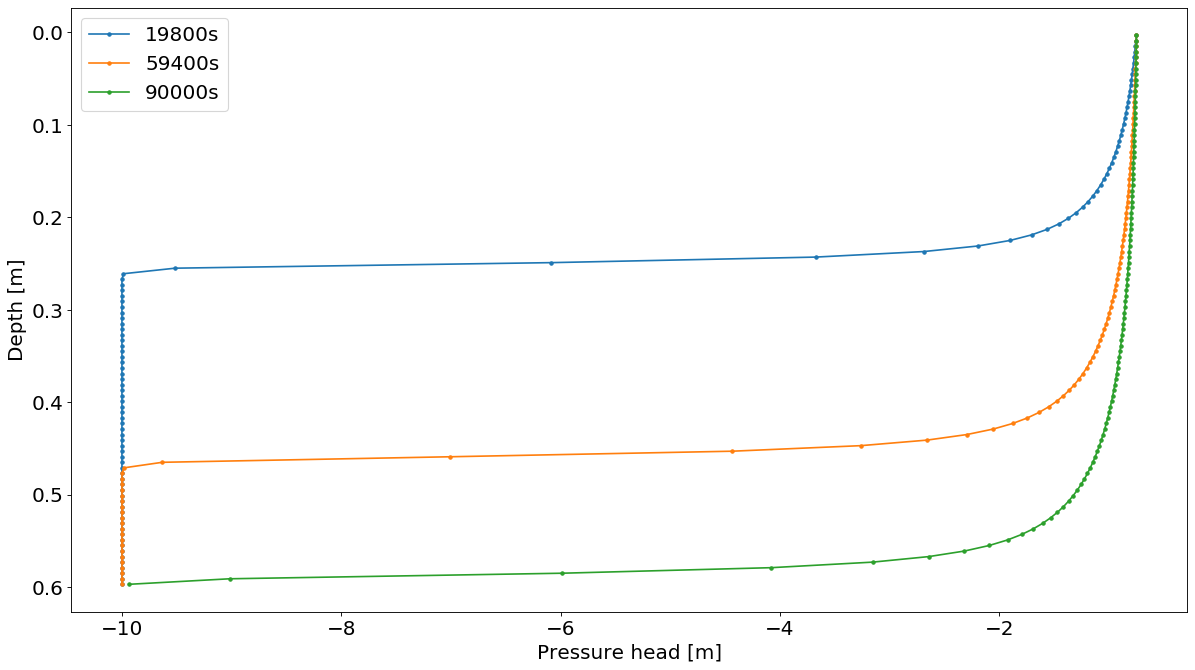

In [8]:
# Open a figure
fig = plt.figure(figsize=(18, 10), dpi= 80, facecolor='w', edgecolor='k');

# Plot the data
for time in timesteps:
    
    # legend label
    time_cur = ds['time'][time].dt.round('s') # Extract time @ timestep, rounded to the nearest second
    time_dif = pd.to_datetime(time_cur.data) - time_ref # time_cur is a datetime64 object, needs to be datetime
    lbl = str(round(time_dif.total_seconds())) + 's' # round() gets rid of the decimal 0 that's added by default
    
    # data
    plt.plot(ds['mLayerMatricHead'].isel(time=time,midToto=midToto), ds['mLayerHeight'].isel(time=time), \
             marker='.', label=lbl);

# Make sure that increasing depth points downward
plt.gca().invert_yaxis()

# Labels
plt.xlabel('Pressure head [m]'); # note, ';' supresses output from the Text object that is created for the labels
plt.ylabel('Depth [m]');
plt.legend();

# Save the figure
plt.savefig('img/lt1_celia1990.png');

## Water balance
The Celia test case simulates infiltration into a soil column. Its boundary conditions restrict simulations to unsaturated flow in the soil column and drainage from the soil column. The water balance equation is:

\begin{equation}
    \Delta S = (infiltration - drainage)*\Delta t
\end{equation}

In [49]:
def components_waterBalance(file_name, inMM = 0):
    
    # Open the dataset
    ds = xr.open_dataset( sim_path / sim_name ).isel(hru=0, gru=0).load()
    
    # Find the time step size [s]
    dt = ((ds['time'].isel(time=1) - ds['time'].isel(time=0))/np.timedelta64(1,'s')).round().values
    
    # Find the midToto indices that are not -9999
    # Note, we know there is no snow in this simulation so we can assume that what works for t=0 works for all t
    layerMask = (ds['mLayerDepth'].isel(time=0) != -9999).values 
    
    # Make a storage depth variable: [m] water in the soil column
    storage = (ds['mLayerVolFracWat'].isel(midToto=layerMask) * \
               ds['mLayerDepth'].isel(midToto=layerMask)).sum(dim='midToto') # [-]*[m]
    
    # Storage change vectors
    s_ini = storage.isel(time=slice(0,-1)).values # initial storage on each time step (i.e. final storage on preceding time step)
    s_fin = storage.isel(time=slice(1, None)).values # final storage on each time step
    d_storage = (s_fin - s_ini) # storage change over each time step
    
    # Fluxes
    inflow =  dt * ds['scalarInfiltration'].isel(time=slice(1, None)) 
    outflow = dt * ds['basin__AquiferRecharge'].isel(time=slice(1, None))
    
    if inMM:
        return d_storage*1000, inflow*1000, outflow*1000
    else:
        return d_storage, inflow, outflow

In [50]:
def plot_waterBalance(ax, d_storage, inflow, outflow, title, inMM):
    
    ax.plot(inflow - outflow, label=r'Inflow - Outflow')
    ax.plot(d_storage, linestyle='--', label='$\Delta S$')
    ax.legend()
    ax.set_xlabel('Timestep')
    if inMM:
        titleUnit = 'mm'
    else:
        titleUnit = 'm'
    ax.set_ylabel('['+titleUnit+']')
    ax.set_title(title+'NET WATER BALANCE = {:10.9f} '.format((inflow - outflow - d_storage).sum().values)+titleUnit)
    
    return     

In [7]:
# Specify that we want [mm]
inMM = 1

In [51]:
# Backward Euler results
sim_path = Path("./output")
sim_name = 'celia1990_test_wb_timestep.nc'
d_storage_be, inflow_be, outflow_be = components_waterBalance(sim_name, inMM)

In [52]:
# IDA results
sim_name = "celia1990_output_timestep.nc"
sim_name = 'celia1990_output_testSumma_timestep.nc'
d_storage_ida, inflow_ida, outflow_ida = components_waterBalance(sim_name, inMM)

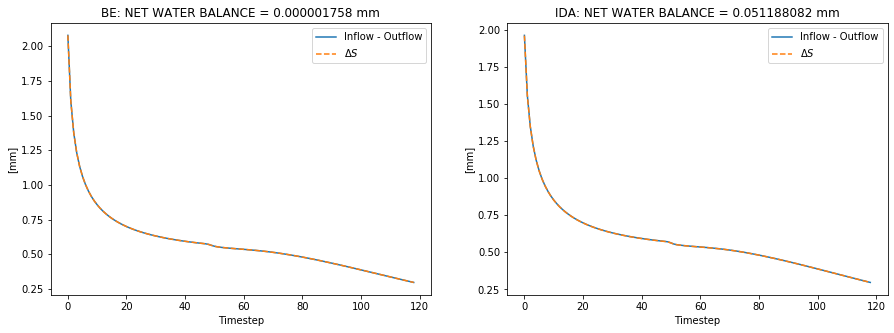

In [53]:
# Plot
fig,ax = plt.subplots(1,2,figsize=(15,5))

plot_waterBalance(ax[0],d_storage_be, inflow_be, outflow_be, 'BE: ', inMM)
plot_waterBalance(ax[1],d_storage_ida,inflow_ida,outflow_ida,'IDA: ', inMM)

# save
plt.savefig('celia_water_balance_comparison_new.png')

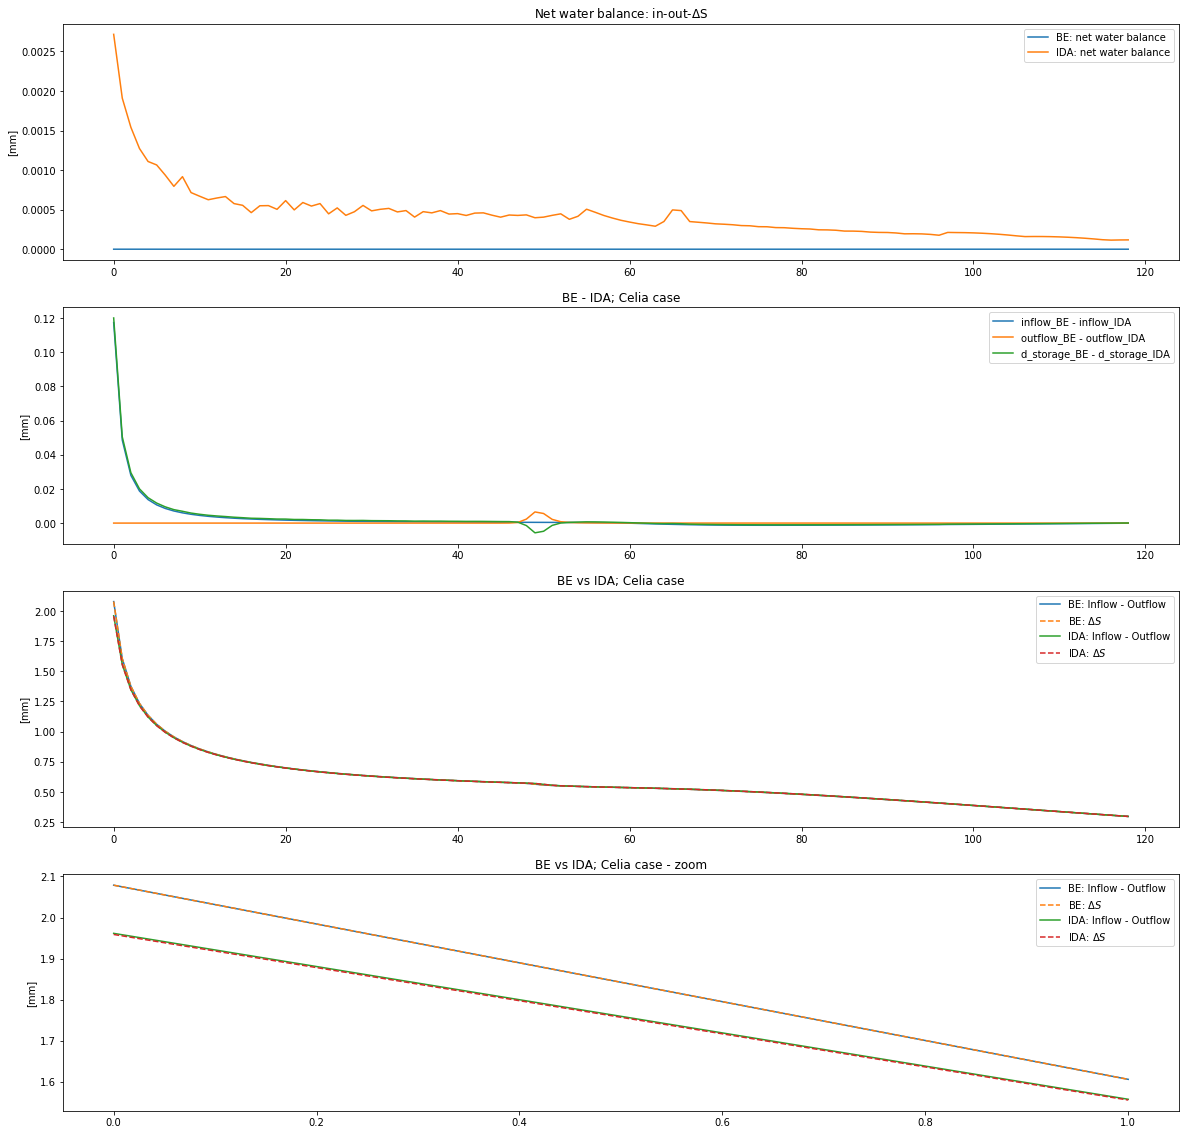

In [11]:
# 2-in-1 plot
fig,ax = plt.subplots(4,1,figsize=(20,20))
titleUnit = 'mm'

# --- individual plots
axId = 2
# BE
ax[axId].plot(inflow_be - outflow_be, label=r'BE: Inflow - Outflow');
ax[axId].plot(d_storage_be, linestyle='--', label='BE: $\Delta S$');

# IDA
ax[axId].plot(inflow_ida - outflow_ida, label=r'IDA: Inflow - Outflow');
ax[axId].plot(d_storage_ida, linestyle='--', label='IDA: $\Delta S$');

# text
ax[axId].legend();
ax[axId].set_title('BE vs IDA; Celia case')
ax[axId].set_xlabel = 'time step';
ax[axId].set_ylabel('['+titleUnit+']');

# --- difference plots
axId = 1
ax[axId].plot(inflow_be - inflow_ida, label=r'inflow_BE - inflow_IDA')
ax[axId].plot(outflow_be - outflow_ida, label=r'outflow_BE - outflow_IDA')
ax[axId].plot(d_storage_be - d_storage_ida, label=r'd_storage_BE - d_storage_IDA')

# text
ax[axId].legend();
ax[axId].set_title('BE - IDA; Celia case');
ax[axId].set_xlabel = 'time step';
ax[axId].set_ylabel('['+titleUnit+']');

# --- zoom on initial time steps
axId = 3
zoomWindow = [0,2]
# BE
ax[axId].plot(inflow_be.isel(time=slice(zoomWindow[0],zoomWindow[1])) - \
              outflow_be.isel(time=slice(zoomWindow[0],zoomWindow[1])), label=r'BE: Inflow - Outflow');
ax[axId].plot(d_storage_be[zoomWindow[0]:zoomWindow[1]], linestyle='--', label='BE: $\Delta S$');

# IDA
ax[axId].plot(inflow_ida.isel(time=slice(zoomWindow[0],zoomWindow[1])) - \
              outflow_ida.isel(time=slice(zoomWindow[0],zoomWindow[1])), label=r'IDA: Inflow - Outflow');
ax[axId].plot(d_storage_ida[zoomWindow[0]:zoomWindow[1]], linestyle='--', label='IDA: $\Delta S$');

# text
ax[axId].legend();
ax[axId].set_title('BE vs IDA; Celia case - zoom');
ax[axId].set_xlabel = 'time step';
ax[axId].set_ylabel('['+titleUnit+']');

# --- water balance comparison
axId = 0

ax[axId].plot(inflow_be - outflow_be - d_storage_be, label=r'BE: net water balance');
ax[axId].plot(inflow_ida - outflow_ida -d_storage_ida, label=r'IDA: net water balance');

# text
ax[axId].legend()
ax[axId].set_xlabel = 'time step';
ax[axId].set_ylabel('['+titleUnit+']');
ax[axId].set_title(r'Net water balance: in-out-$\Delta$S');

# save
plt.savefig('celia_water_balance_diagnostic_new.png')

## Compare .nc variables to internal SUMMA checks

In [69]:
def components_waterBalance2(file_name, inMM = 0):
    
    # Open the dataset
    ds = xr.open_dataset( sim_path / sim_name ).isel(hru=0, gru=0).load()
    
    # Find the time step size [s]
    dt = ((ds['time'].isel(time=1) - ds['time'].isel(time=0))/np.timedelta64(1,'s')).round().values
    
    # Find the midToto indices that are not -9999
    # Note, we know there is no snow in this simulation so we can assume that what works for t=0 works for all t
    layerMask = (ds['mLayerDepth'].isel(time=0) != -9999).values 
    
    # Make a storage depth variable: [m] water in the soil column
    storage = (ds['mLayerVolFracWat'].isel(midToto=layerMask) * \
               ds['mLayerDepth'].isel(midToto=layerMask)).sum(dim='midToto') # [-]*[m]
    
    # Storage change vectors
    s_ini = storage.isel(time=slice(0,-1)).values # initial storage on each time step (i.e. final storage on preceding time step)
    s_fin = storage.isel(time=slice(1, None)).values # final storage on each time step
    d_storage = (s_fin - s_ini) # storage change over each time step
    
    # Fluxes
    inflow =  dt * ds['iLayerLiqFluxSoil'].isel(ifcSoil=0, time=slice(1, None)) 
    outflow = dt * ds['iLayerLiqFluxSoil'].isel(ifcSoil=-1,time=slice(1, None))
    
    if inMM:
        return d_storage*1000, inflow*1000, outflow*1000
    else:
        return d_storage, inflow, outflow

In [67]:
inMM = 1

In [68]:
sim_path = Path("./output")
sim_name = "celia1990_output_timestep.nc"

In [70]:
d_storage_ida, inflow_ida, outflow_ida = components_waterBalance2(sim_name, inMM)

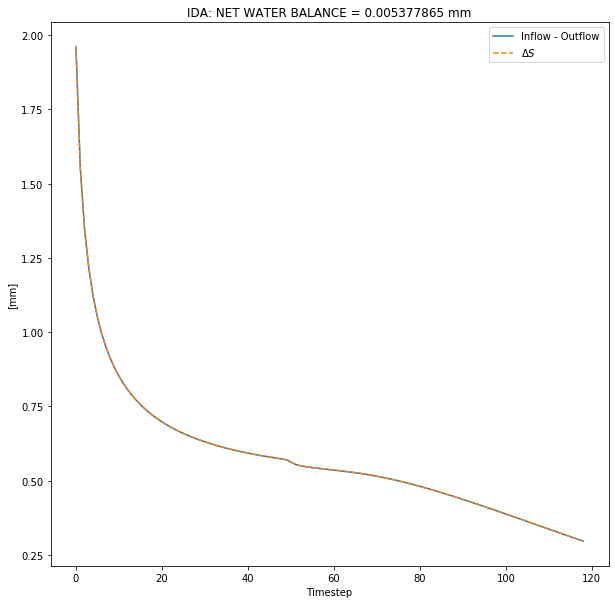

In [73]:
fig,ax = plt.subplots(1,1,figsize=(10,10))
plot_waterBalance(ax,d_storage_ida,inflow_ida,outflow_ida,'IDA: ', inMM)

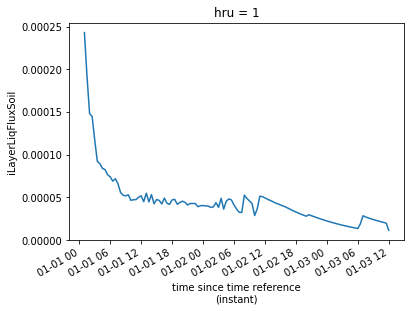

In [74]:
(inflow_ida - outflow_ida - d_storage_ida).plot()

# Old stuff - ignore

In [43]:
# Check that time step length in [s]
dt = ((ds['time'].isel(time=1) - ds['time'].isel(time=0))/np.timedelta64(1,'s')).round().values
print('Time step length = '+str(dt)+' s.')

Time step length = 1800.0 s.


In [35]:
# Find the midToto indices that are not -9999
# note, we know there is no snow in this simulation so we can assume that what works for t=0 works for all t
layerMask = (ds['mLayerDepth'].isel(time=0) != -9999).values 

In [39]:
# Calculate storage [mm] from volumetric fraction of water and layer depth
storage = (ds['mLayerVolFracWat'].isel(midToto=layerMask) * \
    ds['mLayerDepth'].isel(midToto=layerMask)) * 1000 # [m] > [mm]

In [50]:
# Storage change
s_ini = storage.isel(time=0 ).sum().values
s_fin = storage.isel(time=-1).sum().values
print(s_ini,s_fin)

70.68283237658508 139.94260095750093


In [44]:
# Get the input of water into the soil over the simulation
var = 'scalarInfiltration'
flux_in = (ds[var] * dt).sum().values * 1000 # [m s-1] * [s] * 1000 = [mm]
print('Infiltration into the soil during the simulation = '+str(flux_in)+' mm.')

Infiltration into the soil during the simulation = 75.08343420079854 mm.


In [45]:
# Get the drainage of water from the soil over the simulation
var = 'basin__AquiferRecharge'
flux_out = (ds[var] * dt).sum().values * 1000 # [m s-1] * [s] * 1000 = [mm]
print('Drainage from the soil during the simulation = '+str(flux_out)+' mm.')

Drainage from the soil during the simulation = 1.2116824455665631 mm.


In [52]:
# print a report
print('-- water balance check --')
print('in             = '+str(flux_in)+' mm')
print('out            = '+str(flux_out)+' mm')
print('storage change = '+str(s_fin - s_ini)+ ' mm')
print('in-out-change  = '+str(s_ini + flux_in - flux_out - s_fin)+' mm')

-- water balance check --
in             = 75.08343420079854 mm
out            = 1.2116824455665631 mm
storage change = 69.25976858091585 mm
in-out-change  = 4.611983174316123 mm
